# Process

In [1]:
#  standardize or normalize every numerical feature
# extract features from the names and add in seperate keywords column
# fill in actual_price of all instances
# should we remove instances?
# Vectorization 


# figure out if our model will need to handle Nan values
# what model and techique to Use

In [2]:
%pip install nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from nltk.stem import PorterStemmer
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
# converting csv files to dataframes which are values of a dict called dataframes. keys are csv file names

def get_dfs_from_csvs(directory):
    dataframes = {}
    for filename in os.listdir(directory):             # get all csv files in directory
        filepath = os.path.join(directory, filename)   # join file name with directory to acess files for df (directory/filenane)
        df_name = os.path.splitext(filename)[0]        # remove extension .csv and give name of file
        df_name = df_name.lower()
        df = pd.read_csv(filepath)

        if not df.empty: 
            dataframes[df_name] = df   # creates dfs of all non-empty files in a dict
    return dataframes

dataframes = get_dfs_from_csvs('data')

In [4]:
# combining all of the toy datasets in one df because sub_category is different (shop names), otherwise they are same 
def combine_toyDF(dataframes):
    toy_dfs = []
    dfs_to_remove = []
    for dataframe_name in dataframes:
        if 'toy' in dataframe_name.lower():
            toy_dfs.append(dataframes[dataframe_name])
            dfs_to_remove.append(dataframe_name)

    for dataframe_name in dfs_to_remove:      # remove all the dfs which will be combined
        dataframes.pop(dataframe_name)

    toy_df = pd.concat(toy_dfs, ignore_index=True)     # combining step
    toy_df['sub_category'] = "toys and games"          # every value in the sub_category should be "Toys and Games"
    dataframes["toys and games"] = toy_df

    return dataframes

dataframes = combine_toyDF(dataframes)

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,"Ravensburger 3D Puzzles Big Ben Night Edition,...",toys & baby products,toys and games,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/Ravensburger-Puzzles-Nig...,4.6,"5,017",NaN,"₹6,752"
1,Ravensburger San Juan Bopard Game,toys & baby products,toys and games,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/Ravensburger-Board-Games...,4.5,413,"₹7,391","₹11,600"
2,"WWE Elite Figure 1 Daniel Bryan, Black",toys & baby products,toys and games,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/WWE-Elite-Figure-Daniel-...,4.2,30,NaN,"₹11,823"
3,"Zometool Basic Creator Kit, Multi Color",toys & baby products,toys and games,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/Zometool-Basic-Creator-M...,4.0,28,NaN,"₹4,847"
4,Snap Circuits Motion Kit,toys & baby products,toys and games,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/Snap-Circuits-SCM-165-Mo...,4.8,583,NaN,"₹12,516.90"


In [5]:
# Auxillary functions
def extract_numbers(value):
    number = int(''.join(re.findall('\d', value)))

    try:
        return number
    except:
        return None
    
def stemming_words(text):
    """ stems each word of text to its base word
    """
    stemmer = PorterStemmer()
    words = text.split(' ')
    stemmed_words = []

    for word in words:
        stemmed_word = stemmer.stem(word)
        stemmed_words.append(stemmed_word)

    return ' '.join(stemmed_words)



# Data Cleaning and organizing

In [6]:
# from here ADD IN REPORT
# 1. Removing unecessary columns
#     necessary columns: "name", 'main_category', 'sub_category', 'ratings', 'no_of_ratings', 'actual_price', 'discount_price'

# 2. removing ₹ signs and , from discount_price and actual_price
# 3. removing , from no_of_ratings
# 4. convert 'ratings', 'no_of_ratings', 'actual_price', 'discount_price' to float/int
# 5. remove duplicates
# 6. convert actual_price and discount_price to euros
# 7. derive keywords from name - clean and stem them
# 8. convert main_category and sub_category to lowercase and only get the words in these categories
# 9 Impute missing vals
imputer = SimpleImputer(strategy='mean')
exchange_rate = 0.011
for dataframe_name in dataframes:
    # 1
    df = dataframes[dataframe_name][['name', 'main_category', 'sub_category', 'ratings', 'no_of_ratings', 'actual_price', 'discount_price']].copy()  #copy to avoid affecting orignal df whichmight cause errors
    # 2
    df['actual_price'] = df['actual_price'].astype(str).str.replace('₹', '').str.replace(',', '')        # convert all column values to str first to avoid error
    df['discount_price'] = df['discount_price'].astype(str).str.replace('₹', '').str.replace(',', '')
    # 3
    df['no_of_ratings'] = df['no_of_ratings'].astype(str).str.replace(',', '')     
    # 4
    df['no_of_ratings'] = pd.to_numeric(df['no_of_ratings'], errors ='coerce', downcast='integer')      # any value not converatble to float will be set to NaN (coerce)
    df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')
    df['actual_price'] = pd.to_numeric(df['actual_price'], errors='coerce')
    df['discount_price'] = pd.to_numeric(df['discount_price'], errors='coerce')
    # 5
    df.drop_duplicates(inplace=True)
    # 6
    df['actual_price'] *= exchange_rate
    df['discount_price'] *= exchange_rate
    # 7
    df['keywords'] = df['name'].str.lower().replace(r'[^\w\d\s]', '', regex=True)    # removing everything from name which is not a word, digit or a space
    df['keywords'] = df['keywords'].apply(stemming_words)
    # 8
    df['sub_category'] = df['sub_category'].str.lower().replace(r'[^\w]', '', regex=True)    # removing everything from name which is not a word and combining words
    df['main_category'] = df['main_category'].str.lower().replace(r'[^\w]', '', regex=True)
    # 9 
    df['discount_price'].fillna(df['discount_price'].mean(), inplace=True)
    df['no_of_ratings'].fillna(df['no_of_ratings'].mean(), inplace=True)
    df['ratings'].fillna(df['ratings'].mean(), inplace=True)

    dataframes[dataframe_name] = df


# remove ₹ sign. convert to euros

# CCA - dropping instances with missing values

In [38]:
# from here ADD IN REPORT
# check how many total instances
all_products = pd.concat(dataframes.values(), ignore_index=True)
print(f"No. of instances: {all_products.shape[0]}")

# from here ADD IN REPORT
# we see that only these cols have missing vals: ratings, no_of_ratings, discount_price and actual_price 
missing_values = all_products.isnull().sum()
print("missing values: \n",missing_values)

# percent of instances that have missing values in atleast 1 column = 37.71%
# Thus COMPLETE CASE ANALYSIS (CCA) -- (deleting instances with missing values) cannot be applied on data since 1/3rd of data has missing values  
instances_with_missing_values = all_products.isnull().any(axis=1).sum()
total_rows = len(all_products)
percent_missing_instances = (instances_with_missing_values / total_rows) * 100
print("Percentage of instances with missing values before CCA: {:.2f}%".format(percent_missing_instances))

# percent of instances that have missing values in all 4 columns above mentioned simultaneously = 1.52% -- we caould delete these instances 

columns_with_missing_values = all_products.columns[all_products.isnull().any()]
instances_with_all_missing_values = all_products[all_products[columns_with_missing_values].isnull().all(axis=1)]
percent_instances_all_missing_values = (len(instances_with_all_missing_values) / total_rows) * 100
print("Percentage of instances with missing values in all columns with at least one missing value: {:.2f}%".format(percent_instances_all_missing_values))

No. of instances: 515531
missing values: 
 name                  0
main_category         0
sub_category          0
ratings               0
no_of_ratings         0
actual_price      14276
discount_price        0
keywords              0
dtype: int64
Percentage of instances with missing values before CCA: 2.77%
Percentage of instances with missing values in all columns with at least one missing value: 2.77%


In [39]:
# from here ADD IN REPORT
all_products_beforeCCA = all_products.copy()
# Thus apply COMPLETE CASE ANALYSIS (CCA) on the 1.52% of data where simultaneously all 4 cols have missing values because it is < 5% -- research paper for this - I watched in a video
subset = ['ratings', 'no_of_ratings', 'actual_price', 'discount_price']
all_products.dropna(subset=subset, how='all', inplace=True)
all_products.reset_index(drop=True, inplace=True)

# percent of instances that have missing values per column before CCA
missing_values = all_products.isnull().mean() * 100
print("missing values: \n",missing_values)

missing values: 
 name              0.000000
main_category     0.000000
sub_category      0.000000
ratings           0.000000
no_of_ratings     0.000000
actual_price      2.769184
discount_price    0.000000
keywords          0.000000
dtype: float64


In [40]:
# from here ADD IN REPORT
# apply COMPLETE CASE ANALYSIS (CCA) on actual_price because only 1.27% < 5% -- see above cell
all_products.dropna(subset=['actual_price'], inplace=True)
all_products.reset_index(drop=True, inplace=True)

# percent of instances that have missing values in atleast 1 column after CCA = 35.93%
instances_with_missing_values = all_products.isnull().any(axis=1).sum()
total_rows = len(all_products)
percent_missing_instances = (instances_with_missing_values / total_rows) * 100
print("Percentage of instances with missing values after CCA: {:.2f}%".format(percent_missing_instances))
# percent of instances that have missing values per column before CCA
missing_values = all_products.isnull().mean() * 100
print("missing values: \n",missing_values)

Percentage of instances with missing values after CCA: 0.00%
missing values: 
 name              0.0
main_category     0.0
sub_category      0.0
ratings           0.0
no_of_ratings     0.0
actual_price      0.0
discount_price    0.0
keywords          0.0
dtype: float64


In [41]:
# from here ADD IN REPORT
# what percentage of the instances that have missing values in ratings column also have missing values in no_of_ratings
missing_ratings_and_no_of_ratings = all_products[(all_products['ratings'].isnull()) & (all_products['no_of_ratings'].isnull())].shape[0]
missing_ratings = all_products['ratings'].isnull().sum()
percentage = (missing_ratings_and_no_of_ratings / missing_ratings) * 100

print("Percentage of instances with missing values in ratings column also having missing values in no_of_ratings column: {:.2f}%".format(percentage))
print(f"Number of instances after CCA: {all_products.shape[0]}")
# Answer 100% -- So cannot CCA on common instances with missing vals in ratings and no_of_ratings 

Percentage of instances with missing values in ratings column also having missing values in no_of_ratings column: nan%
Number of instances after CCA: 501255


C:\Users\Hp\AppData\Local\Temp\ipykernel_18468\2439521076.py:5: RuntimeWarning: invalid value encountered in scalar divide
  percentage = (missing_ratings_and_no_of_ratings / missing_ratings) * 100


<Figure size 1200x600 with 0 Axes>

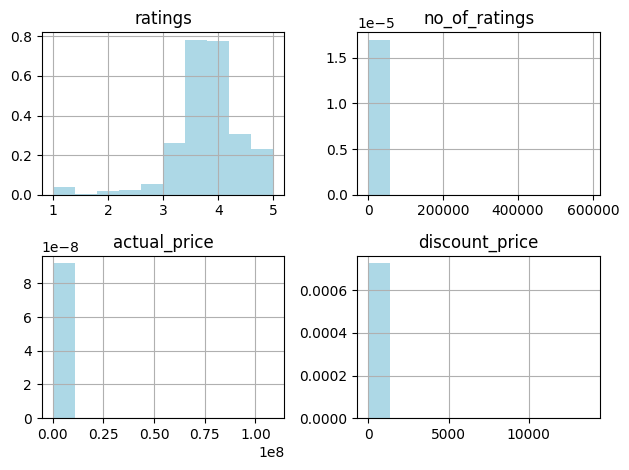

<Figure size 1200x600 with 0 Axes>

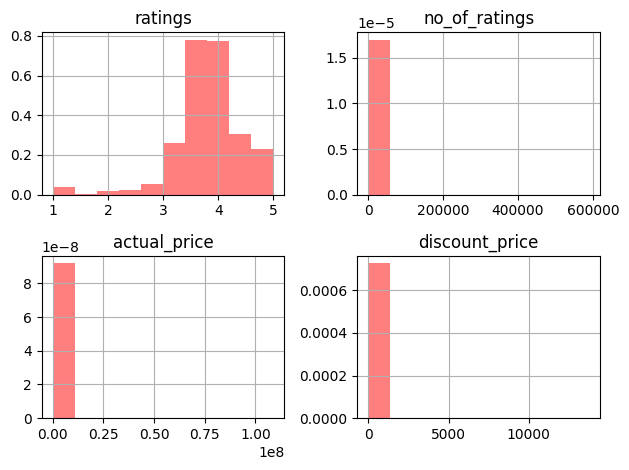

In [42]:
# from here ADD IN REPORT -- side by side. blue one is before CCA, red is after CCA
# Distribution in both is almost similar, thus performing CCA was the right choice!
import matplotlib.pyplot as plt

# Distribution of numerical features with missing values before CCA
plt.figure(figsize=(12, 6))
all_products_beforeCCA.hist(bins=10, density=True, color='lightblue')
plt.tight_layout()
plt.show()

# Distribution of numerical features with missing values after CCA
plt.figure(figsize=(12, 6))
all_products.hist(bins=10, density=True, color='red', alpha=0.5)
plt.tight_layout()
plt.show()


# Sampling 20k instances from whole dataset

In [12]:
all_products.head(1) /!

SyntaxError: invalid syntax (732443839.py, line 1)

In [43]:
# ADD TO REPORT
# Performing STRATIFIED SAMPLING: Dividing population into subgroups (by subcategory) and then randomly selecting samples from each subcategory based on the proportion of instances 
# having that subcategory to the entire dataset (500k instances).  --- each instance in a subcategory has equal probability of getting selected --- formula for probability

num_instances = 20000
subcategory_proportions = all_products['sub_category'].value_counts(normalize=True)

sampled_data = pd.DataFrame()
for subcategory, proportion in subcategory_proportions.items():

     
    subcategory_data = all_products[all_products['sub_category'] == subcategory]     # get the instances where sub_category = subcategory

    # Calculate the number of samples to take from this subcategory based upon its proportin to the entire dataset and how many total instances we want to have in final dataset
    num_samples = int(proportion * num_instances)

    # Sample the required number of instances from this subcategory 
    subcategory_samples = subcategory_data.sample(n=num_samples, random_state=42)

    # Add the sampled data for this subcategory to the overall sampled dataset
    sampled_data = pd.concat([sampled_data, subcategory_samples])

# Shuffle the sampled data to ensure randomness
all_products = sampled_data.sample(frac=1, random_state=42)

In [ ]:
all_products.shape

(501255, 8)

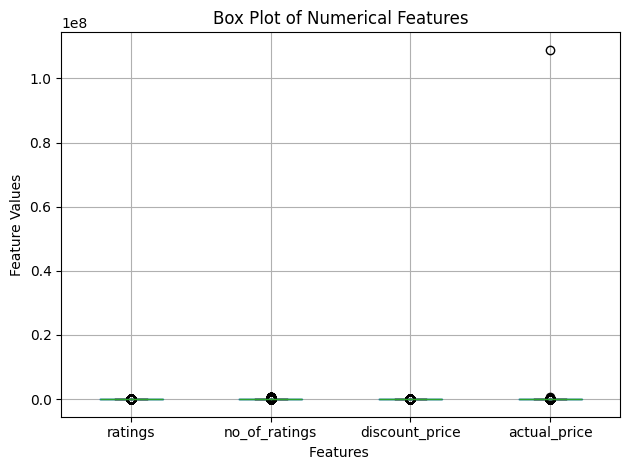

In [ ]:
numerical_features = ['ratings', 'no_of_ratings', 'discount_price', 'actual_price']
all_products[numerical_features].boxplot()
plt.title('Box Plot of Numerical Features')
plt.xlabel('Features ')
plt.ylabel('Feature Values')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Assuming 'all_products' is your DataFrame
skewness = all_products['no_of_ratings'].skew()
print("Skewness of 'no_of_ratings' column:", skewness)


Skewness of 'no_of_ratings' column: 41.21315338963986


In [ ]:
print(all_products.describe())

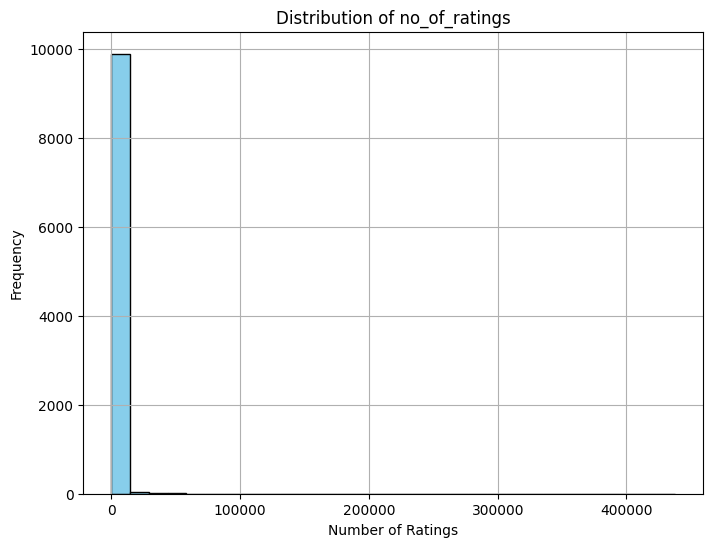

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'all_products' is your DataFrame
plt.figure(figsize=(8, 6))
plt.hist(all_products['no_of_ratings'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of no_of_ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Encoding - One-hot and tfidf

In [ ]:
# from here ADD IN REPORT

# check how many main and sub categories to determine in how many features will main_category and sub_category be expanded by One-hot encoding -- ADD IN REPORT
print('Number of main categories: ', all_products['main_category'].nunique())
print('Number of sub categories: ', all_products['sub_category'].nunique(), '\n')

Number of main categories:  20
Number of sub categories:  109 



In [44]:
# from here ADD IN REPORT

# 2 Encode the textual features in order to convert them to numerical. 
#   2.1 -- main_category and sub_category are categorical, thus we can use one-hot Encoding, Label Encoding or Target Encoding. - Explain shortly about all.
#           we will use one-hot Encoding as these features are nominal and not ordinal. - explain what nominal data means. Inspiration link: https://www.youtube.com/watch?v=U5oCv3JKWKA
#           drop first column of encoded columns to avoid multicollinearity issues. (dummy variable trap) -- explain precisely(read about OH-encoding first)
#   2.2 -- keywords is not categorical and is important for identifying a product. Thus use TF-IDF Vectorization to encode. - Write formula of TF and IDF and explain. 
#           sklearns TfidfVectorizer adds 1 to idf of a term so that value that occurs in all documents does not become redundant = 0
#           inspiration: https://www.youtube.com/watch?v=vo6gQz5lYRI
#           Bag of Words technique using CountVectorizer() gives us more (5000) features in a dense matrix with less memory consumption but chatGPT told that Tfidf is better even in a sparse matrix format -- find research paper on this


# 2.1 keep in mind that after the encoding, the columns on which encoding is not applied will be renamed as remainder__column_name. example: remainder__keywords

def oneHotEncode(all_products): 
    transformer = ColumnTransformer(transformers=[            # using ColumnTransformer to encode in one line without needing to combine columns manually.
        ('ohTransformer', OneHotEncoder(sparse_output=False, drop='first', dtype=np.int32), ['main_category', 'sub_category'])   # (transformer name, encoder type, columns to encode). # avoid sparse matrix and drop first column due to multicollinearity issue
    ], remainder='passthrough')   # remainder parameter for not dropping other columns.

    transformed_matrix = transformer.fit_transform(all_products)

    encoded_column_names = transformer.get_feature_names_out()
    return pd.DataFrame(transformed_matrix, columns=encoded_column_names)
    
all_products = oneHotEncode(all_products)
all_products2 = all_products.copy()               # create a copy for safety
all_products2.drop(columns=['remainder__keywords'], inplace=True)
# 2.2
tfidf_vectorizer = TfidfVectorizer(max_features=5000,stop_words='english',dtype=np.int32)   # using 10k max_words on intuition -- needs experiment. each keyword is now a vector of 10k dimensions
tfidf_vectorizer.fit(all_products['remainder__keywords'])
vectors = tfidf_vectorizer.transform(all_products['remainder__keywords'])     # using sparse matrix because dense matrix takes too much memory  
tfidf_column_names = tfidf_vectorizer.get_feature_names_out()
vector_df = pd.DataFrame.sparse.from_spmatrix(vectors, columns=tfidf_column_names)

all_products = pd.concat([vector_df, all_products2], axis=1)       # combine the vectors which are expanded columns of the keywords column with the other columns

c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:2060: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int32'> 'dtype' will be converted to np.float64.
  warnings.warn(


In [45]:
all_products.shape

(9944, 5129)

# Normalization

In [46]:
# Normalize the numerical features. Normalization chosen because no_of_ratings has outliers. 
# Normalization scales the features 0 and 1 which is less influenced by extreme values. Add formula. Add research paper.

from sklearn.preprocessing import MinMaxScaler

def featureScaling(df, columnsToScale, scaler_type):
    scaler_object = scaler_type()
    df[columnsToScale] = scaler_object.fit_transform(df[columnsToScale])

columnsToNormalize = ['remainder__actual_price', 'remainder__discount_price', 'remainder__no_of_ratings', 'remainder__ratings']
featureScaling(all_products, columnsToNormalize, MinMaxScaler)     # MinMaxScaler for Normalization

In [20]:
all_products.shape

(501255, 5132)

In [21]:
all_products.head(1)

,001,002,01,02,03,04,05,06,07,08,...,ohTransformer__sub_category_washingmachines,ohTransformer__sub_category_watches,ohTransformer__sub_category_westernwear,ohTransformer__sub_category_womensfashion,ohTransformer__sub_category_yoga,remainder__name,remainder__ratings,remainder__no_of_ratings,remainder__actual_price,remainder__discount_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,0.8,0.003823,0.000006,0.026393


# Similarity

In [48]:
all_products_copy = all_products.copy()
name_column = all_products_copy['remainder__name'].copy() # Save the 'name' column in a variable
products_for_similarity = all_products_copy.drop(columns=['remainder__name']).copy() # Drop the 'name' column from all_products
products_matrix = products_for_similarity.values

products_for_similarity.shape

C:\Users\Hp\AppData\Local\Temp\ipykernel_18468\1957202407.py:4: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  products_matrix = products_for_similarity.values


(9944, 5128)

In [24]:
batch_size = 10000
partitions = []

for i in range(0, len(products_for_similarity), batch_size):
    print(i)
    break
    partition = products_for_similarity.iloc[i:i+batch_size]
    partitions.append(partition)



0


In [49]:
# calculate the similarity of each instance to every other instance and store those instances in a vector. do this for every instance. Now each instance becomes a vector
# of n-1 elements with n = number of instances. Sort these vectors and u get the closest instances in the beginning of each vector.

# FIRST DO with COSINE_CIMILARITY and compute precision for the recommendations made. Then try different hyperparameters for KNN and compute precision of 
# recommendations for each hyperparameter chosen. When we get highest precision, that hyperparameter is the best. Impute all values with that hyperparameter
# Then do evaluation for all other similarity metrics


# convert dataframe to matrix

# 1 COSINE SIMILARITY

cosine_matrix = cosine_similarity(products_for_similarity)
cosine_matrix.shape

c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\pairwise.py:45: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  X = np.asarray(X)


(9944, 9944)

In [50]:
def cosine_recommend(product_name, n):
    """ fetches the titles of n most similar movies to movie_name and returns in a list
    """
    product_name = product_name.lower()
    product_index = all_products_copy[all_products_copy['remainder__name'].str.lower() == product_name].index[0]        # get index of the row in data in which remainder__name = product_name 
    distances = cosine_matrix[product_index]                          # get similarity array of requested product 
    index_tracker_products = list(enumerate(distances))              # tracing index of products along with the similarity scores wrt requested product
    nearest_product_scores = sorted(index_tracker_products, reverse=True,key=lambda x: x[1])[1:n+1]      # picking n most similar products (excluding the requested product itself)

    nearest_product_indices = [product[0] for product in nearest_product_scores]
    
    nearest_product_names = [all_products_copy.iloc[i].remainder__name for i in nearest_product_indices]

    return nearest_product_names

In [51]:
def cosine_sim(A, B):
    euclideanNorm_A = 0
    euclideanNorm_B = 0
    dot_product = 0
    for i in range(len(A)):
        euclideanNorm_A += A[i]**2
        euclideanNorm_B += B[i]**2
        dot_product += (A[i]*B[i]) 

    euclideanNorm_A = np.sqrt(euclideanNorm_A)
    euclideanNorm_B = np.sqrt(euclideanNorm_B)
    similarity = dot_product / (euclideanNorm_A*euclideanNorm_B)
    return similarity

cosine_sim([-1,2,0], [1,2,1])

0.5477225575051661

In [101]:
def cosine_sim2(A, B):
    dot_product = np.sum(A * B)
    euclideanNorm_A = np.sqrt(np.sum(A**2))
    euclideanNorm_B = np.sqrt(np.sum(B**2))
    similarity = dot_product / (euclideanNorm_A * euclideanNorm_B)
    return similarity

In [105]:
def cosine_recommend2(product_name, n):
    """ fetches the titles of n most similar movies to movie_name and returns in a list
    """
    product_name = product_name.lower()
    product_index = all_products_copy[all_products_copy['remainder__name'].str.lower() == product_name].index[0]        # get index of the row in data in which remainder__name = product_name 
    
    product_row = products_for_similarity.iloc[product_index].values.reshape(1, -1)            # get the instance whose name is requested as an array using product_index

    similarity_arr = cosine_similarity(product_row, products_for_similarity).flatten()

    # for i in range(len(products_for_similarity)):
    #     other_row = products_for_similarity.iloc[i].values
    #     similarity = cosine_sim(product_row, other_row)
    #     similarity_arr.append((i, similarity))


    nearest_product_scores = sorted(similarity_arr, reverse=True,key=lambda x: x[1])[1:n+1]      # picking n most similar products (excluding the requested product itself)

    nearest_product_indices = [product[0] for product in nearest_product_scores]
    
    nearest_product_names = [all_products_copy.iloc[i].remainder__name for i in nearest_product_indices]

    return nearest_product_names

In [65]:
products_for_similarity.head(1)

,001,002,01,02,025,03,04,05,06,061384,...,ohTransformer__sub_category_wallets,ohTransformer__sub_category_washingmachines,ohTransformer__sub_category_watches,ohTransformer__sub_category_westernwear,ohTransformer__sub_category_womensfashion,ohTransformer__sub_category_yoga,remainder__ratings,remainder__no_of_ratings,remainder__actual_price,remainder__discount_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.711519,0.000613,0.003153,0.002104


In [53]:
input_name = all_products_copy['remainder__name'].iloc[500]

In [79]:
all_products_copy.iloc[0].values[-5]

'EASYDEX Ph Pen Teste Thzy High Accuracy Pocket Size Ph Meter With Atc'

In [55]:
# Test

cosine_recommend(input_name, 5)


['Salepush Travel Foldable Hand Bag Large Capacity Folding Travel Bag, Travel Lightweight Waterproof Carry Duffel Luggage Ba...',
 'Arrowmax Gym Duffle Bag Shoulder Bag Bags Travel Duffel Bags, Ideal for Gym/Swimming and Other Sports kit',
 'Akshar Seven Leather Bag Travel Duffle for Men and Women tylish Trendy Travel Bag for Men Women Duffle Travelling Bag Duff...',
 '5 kg Capacity | Kirana Bags | Grocery Bags| Food Storage Bags | Plastic Bags | LD Bags/LDPE Bags | 13 inch. x 19 inch. x 5...',
 'SZONZ Travel Bags Lightweight Foldable Waterproof Shoulder Handbag,Clothes Storage Duffle Bag Organizer,Travel Bag Luggage...']

In [106]:
cosine_recommend2(input_name, 5)

AttributeError: 'SparseArray' object has no attribute 'reshape'

In [54]:
input_name

'MAVOTANK Picnic Bag for Women Duffel Bag Large Capacity Folding Travel Bag Multifunctional Fitness Travel Bag, Foldable Tr...'

In [ ]:
all_products.head(1)

,001,002,01,02,025,03,04,05,06,061384,...,ohTransformer__sub_category_washingmachines,ohTransformer__sub_category_watches,ohTransformer__sub_category_westernwear,ohTransformer__sub_category_womensfashion,ohTransformer__sub_category_yoga,remainder__name,remainder__ratings,remainder__no_of_ratings,remainder__actual_price,remainder__discount_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,EASYDEX Ph Pen Teste Thzy High Accuracy Pocket...,0.711519,0.000613,0.003153,0.002104
